# LodeSTAR particle shape test

## Load data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset class to make it compatible with the DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load circle
dataset = torch.load('data/dataset_C.pt')
test_dataset_C = dataset['test']
train_dataset_C = dataset['train']
test_dataloader_C = DataLoader(test_dataset_C, batch_size=8, shuffle=False)
train_dataloader_C = DataLoader(train_dataset_C, batch_size=8, shuffle=True)

# Load moon
dataset = torch.load('data/dataset_M.pt')
test_dataset_M = dataset['test']
test_dataloader_M = DataLoader(test_dataset_M, batch_size=8, shuffle=False)

# Load star
dataset = torch.load('data/dataset_S.pt')
test_dataset_S = dataset['test']
test_dataloader_S = DataLoader(test_dataset_S, batch_size=8, shuffle=False)

# Load filament
dataset = torch.load('data/dataset_F.pt')
test_dataset_F = dataset['test']
test_dataloader_F = DataLoader(test_dataset_F, batch_size=8, shuffle=False)

# Load CE
dataset = torch.load('data/dataset_CE.pt')
train_dataset_CE = dataset['train']
test_dataset_CE = dataset['test']
train_dataloader_CE = DataLoader(train_dataset_CE, batch_size=8, shuffle=True)
test_dataloader_CE = DataLoader(test_dataset_CE, batch_size=8, shuffle=False)

# Load CM
dataset = torch.load('data/dataset_CM.pt')
train_dataset_CM = dataset['train']
test_dataset_CM = dataset['test']
train_dataloader_CM = DataLoader(train_dataset_CM, batch_size=8, shuffle=True)
test_dataloader_CM = DataLoader(test_dataset_CM, batch_size=8, shuffle=False)

# Load CS
dataset = torch.load('data/dataset_CS.pt')
train_dataset_CS = dataset['train']
test_dataset_CS = dataset['test']
train_dataloader_CS = DataLoader(train_dataset_CS, batch_size=8, shuffle=True)
test_dataloader_CS = DataLoader(test_dataset_CS, batch_size=8, shuffle=False)

# Load CF
dataset = torch.load('data/dataset_CF.pt')
train_dataset_CF = dataset['train']
test_dataset_CF = dataset['test']
train_dataloader_CF = DataLoader(train_dataset_CF, batch_size=8, shuffle=True)
test_dataloader_CF = DataLoader(test_dataset_CF, batch_size=8, shuffle=False)

# Load CSq
dataset = torch.load('data/dataset_CSq.pt')
train_dataset_CSq = dataset['train']
test_dataset_CSq = dataset['test']
train_dataloader_CSq = DataLoader(train_dataset_CSq, batch_size=8, shuffle=True)
test_dataloader_CSq = DataLoader(test_dataset_CSq, batch_size=8, shuffle=False)

# Load ESq
dataset = torch.load('data/dataset_ESq.pt')
train_dataset_ESq = dataset['train']
test_dataset_ESq = dataset['test']
train_dataloader_ESq = DataLoader(train_dataset_ESq, batch_size=8, shuffle=True)
test_dataloader_ESq = DataLoader(test_dataset_ESq, batch_size=8, shuffle=False)

# Load CEM
dataset = torch.load('data/dataset_CEM.pt')
train_dataset_CEM = dataset['train']
test_dataset_CEM = dataset['test']
train_dataloader_CEM = DataLoader(train_dataset_CEM, batch_size=8, shuffle=True)
test_dataloader_CEM = DataLoader(test_dataset_CEM, batch_size=8, shuffle=False)

# Load CES
dataset = torch.load('data/dataset_CES.pt')
train_dataset_CES = dataset['train']
test_dataset_CES = dataset['test']
train_dataloader_CES = DataLoader(train_dataset_CES, batch_size=8, shuffle=True)
test_dataloader_CES = DataLoader(test_dataset_CES, batch_size=8, shuffle=False)

# Load CEF
dataset = torch.load('data/dataset_CEF.pt')
train_dataset_CEF = dataset['train']
test_dataset_CEF = dataset['test']
train_dataloader_CEF = DataLoader(train_dataset_CEF, batch_size=8, shuffle=True)
test_dataloader_CEF = DataLoader(test_dataset_CEF, batch_size=8, shuffle=False)

# Load CESq
dataset = torch.load('data/dataset_CESq.pt')
train_dataset_CESq = dataset['train']
test_dataset_CESq = dataset['test']
train_dataloader_CESq = DataLoader(train_dataset_CESq, batch_size=8, shuffle=True)
test_dataloader_CESq = DataLoader(test_dataset_CESq, batch_size=8, shuffle=False)

# Load dense
test_dataset_CE_d = torch.load('data/dataset_CE_dense.pt')
test_dataloader_CE_d = DataLoader(test_dataset_CE_d, batch_size=8, shuffle=False)

## Define architecture (LodeSTAR 2.8)

In [2]:
from typing import Callable, Optional

import numpy as np
import scipy
import scipy.ndimage
import torch
import torch.nn as nn
from skimage import morphology

from deeplay import ConvolutionalNeuralNetwork, Application

from deeplay.applications.detection.lodestar.transforms import (
    RandomRotation2d,
    RandomTranslation2d,
    Transforms,
)

import torch.nn.functional as F

class LodeSTAR(Application):

    # num_outputs: int # only 2D for now
    num_classes: int
    transforms: Transforms
    n_transforms: int
    model: nn.Module
    between_loss: Callable
    within_loss: Callable
    between_loss_weight: float
    within_loss_weight: float

    def __init__(
        self,
        model: Optional[nn.Module] = None,
        num_classes: int = 2,
        transforms: Optional[Transforms] = None,
        n_transforms: int = 2,
        between_loss: Optional[Callable] = None,
        within_loss: Optional[Callable] = None,
        between_loss_weight: float = 1,
        within_loss_weight: float = 10,
        **kwargs
    ):
        if transforms is None:
            transforms = Transforms(
                [
                    RandomTranslation2d(),
                    RandomRotation2d(),
                ]
            )

        self.num_classes = num_classes
        self.transforms = transforms
        self.n_transforms = n_transforms
        self.model = model or self._get_default_model()
        self.between_loss = between_loss or nn.L1Loss(reduction="mean")
        self.within_loss = within_loss or nn.L1Loss(reduction="mean")
        self.between_loss_weight = between_loss_weight
        self.within_loss_weight = within_loss_weight

        self.losses = {
            'between_image_disagreement': [],
            'within_image_disagreement': [],
            'mask_loss': []
        }

        super().__init__(loss=self.compute_loss, **kwargs)

    def _get_default_model(self):
        cnn = ConvolutionalNeuralNetwork(
            None,
            [32, 32, 64, 64, 64, 64, 64, 64, 64],
            (2 + 1) + (self.num_classes + 1),  # (num_outputs + 1) + (num_classes +1)
        )
        cnn.blocks[2].pooled()

        return cnn

    def transform_data(self, batch):
        repeated = batch.repeat_interleave(self.n_transforms, dim=0)
        transformed, inverse = self.transforms(repeated)
        return transformed, inverse

    def forward(self, x):

        if self.training:
            x, class_label = x

        out = self.model(x)
        y = out[:, :3, ...]
        classes=out[:, 3:, ...]
        classes = nn.functional.gumbel_softmax(classes, hard=True, dim=1)

        batch_size = classes.size(0)
        num_channels = classes.size(1)
        _, _, Hx, Wx = x.shape
        _, _, Hy, Wy = y.shape
        x_range = torch.arange(Hy, device=x.device) * Hx / Hy
        y_range = torch.arange(Wy, device=x.device) * Wx / Wy
        
        if self.training:
            x_range = x_range - Hx / 2 + 0.5
            y_range = y_range - Wx / 2 + 0.5

            batch_indices = torch.arange(batch_size)

            mask = classes[batch_indices,  class_label.squeeze(), :, :][:,None]
        else:
            
            mask = classes.sum(dim=1)[:,None]#torch.ones_like(y[:, 2:3, ...])


        Y, X = torch.meshgrid(y_range, x_range, indexing="xy")

        delta_x = y[:, 0:1, ...]
        delta_y = y[:, 1:2, ...]
        yy = y[:, 2:3, ...]
        weights = y[:, 2:3, ...].sigmoid()
        X = X + delta_x
        Y = Y + delta_y
        
        return torch.cat(
            [X, Y, weights, mask, classes], dim=1
        )

    def normalize(self, weights):
        weights = weights + 1e-5
        return weights / weights.sum(dim=(2, 3), keepdim=True)

    def reduce(self, X, weights):
        return (X * weights).sum(dim=(2, 3)) / weights.sum(dim=(2, 3))

    def compute_loss(self, y_hat, inverse_fn):
        B = y_hat.size(0) / self.n_transforms

        y_pred, weights, mask_gumbel, classes = y_hat[:, :2], y_hat[:, 2:3], y_hat[:, 3:4], y_hat[:, 4:]
        
        weights =  mask_gumbel
        weights = self.normalize(weights)
        y_reduced = self.reduce(y_pred, weights)

        within_disagreement = (y_pred - y_reduced[..., None, None]) * weights 
        within_disagreement_loss = self.within_loss(
            within_disagreement, torch.zeros_like(within_disagreement)
        )

        y_reduced_on_initial = inverse_fn(y_reduced)

        between_disagreement_loss = 0

        for i in range(0, y_pred.size(0), self.n_transforms):
            batch_preds = y_reduced_on_initial[i : i + self.n_transforms]
            batch_mean_pred = batch_preds.mean(dim=0, keepdim=True).expand_as(
                batch_preds
            )
            between_disagreement_loss += (
                self.between_loss(batch_preds, batch_mean_pred) / B
            )
        weighted_between_loss = between_disagreement_loss * self.between_loss_weight
        weighted_within_loss = within_disagreement_loss * self.within_loss_weight
        
        compl_mask=classes[:,:-1,...].sum(dim=1)[:,None]-mask_gumbel
        mask_loss = 10*compl_mask.mean(dim=(2, 3)).mean()

        self.save_losses({
            'between_image_disagreement': weighted_between_loss.item(),
            'within_image_disagreement': weighted_within_loss.item(),
            'mask_loss': mask_loss.item()
        })

        return {
            "between_image_disagreement": weighted_between_loss,
            "within_image_disagreement": weighted_within_loss,
            "mask_loss": mask_loss
        }

    def save_losses(self, current_losses):
        for key, value in current_losses.items():
            self.losses[key].append(value)

    def get_losses(self):
        return self.losses

    def plot_losses(self):
        import matplotlib.pyplot as plt

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Losses')
        for ax, (key, values) in zip(axs.ravel(), self.losses.items()):
            ax.plot(values)
            ax.set_title(key)
            ax.set_xlabel('Iterations')
            ax.set_ylabel('Loss')
        plt.tight_layout()
        plt.show()

    def on_train_end(self) -> None:
        self.eval()
        self.plot_losses()
        return super().on_train_end()

    def detect(self, x, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"):
        """Detects objects in a batch of images

        Parameters
        ----------
        x : array-like
            Input to model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        y = self(x.to(self.device))
        y_pred, weights, mask_gumbel = y[:, :2], y[:, 2:3], y[:, 4:4+self.num_classes]

        detections = []
        for i in range(len(y_pred)):
            sample_detections = []
            for j in range(self.num_classes):
                mask = mask_gumbel[:, j:j+1, :, :] #* weights
                detection = self.detect_single(y_pred[i], mask[i], alpha, beta, cutoff, mode)
                sample_detections.append(detection)
            
            # Convert the list of arrays to a single 2D array
            sample_detections = np.vstack(sample_detections)
            detections.append(sample_detections)

        return detections
    
    def detect_single(
        self, y_pred, weights, alpha=0.5, beta=0.5, cutoff=0.97, mode="quantile"
    ):
        """Detects objects in a single image

        Parameters
        ----------
        y_pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        cutoff: float
            Threshold for detection
        mode: string
            Mode for thresholding. Can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.
        """
        score = self.get_detection_score(y_pred, weights, alpha, beta)
        return self.find_local_maxima(y_pred, score, cutoff, mode)
    
    @classmethod
    def get_detection_score(cls, pred, weights, alpha=0.5, beta=0.5):
        """Calculates the detection score as weights^alpha * consistency^beta.

        Parameters
        ----------
        pred, weights: array-like
            Output from model
        alpha, beta: float
            Geometric weight of the weight-map vs the consistenct metric for detection.
        """
        return (
            weights[0].detach().cpu().numpy() ** alpha
            * cls.local_consistency(pred) ** beta
        )
    
    @staticmethod
    def local_consistency(pred):
        """Calculate the consistency metric

        Parameters
        ----------
        pred : array-like
            first output from model
        """
        pred = pred.permute(1, 2, 0).cpu().detach().numpy()
        kernel = np.ones((3, 3, 1)) / 3**2
        pred_local_squared = scipy.signal.convolve(pred, kernel, "same") ** 2
        squared_pred_local = scipy.signal.convolve(pred**2, kernel, "same")
        squared_diff = (squared_pred_local - pred_local_squared).sum(-1)
        np.clip(squared_diff, 0, np.inf, squared_diff)
        return 1 / (1e-6 + squared_diff)
    
    @staticmethod
    def find_local_maxima(pred, score, cutoff=0.9, mode="quantile"):
        """Finds the local maxima in a score-map, indicating detections

        Parameters
            ----------
        pred, score: array-like
            Output from model, score-map
        cutoff, mode: float, string
            Treshholding parameters. Mode can be either "quantile" or "ratio" or "constant". If "quantile", then
            `ratio` defines the quantile of scores to accept. If "ratio", then cutoff defines the ratio of the max
            score as threshhold. If constant, the cutoff is used directly as treshhold.

        """
        score = score[3:-3, 3:-3]
        th = cutoff
        if mode == "quantile":
            th = np.quantile(score, cutoff)
        elif mode == "ratio":
            th = np.max(score.flatten()) * cutoff
        th += 1e-6 # to avoid h = 0 error
        hmax = morphology.h_maxima(np.squeeze(score), th) == 1
        hmax = np.pad(hmax, ((3, 3), (3, 3)))
        detections = pred.permute(1, 2, 0).detach().cpu().numpy()[hmax, :]
        return np.array(detections)

    def pooled(self, x, mask=1):
        """Pooled output from model.

        Predict and pool the output from the model. Useful to acquire a single output from the model.
        Masking is supported by setting the mask to 0 where the output should be ignored.

        Parameters
        ----------
        x : array-like
            Input to model
        mask : array-like
            Mask for pooling. Should be the same shape as the output from the model with a single channel.
        """
        y = self(x.to(self.device))
        y_pred, weights,  = y[:, :2], y[:, 2:3]
        masked_weights = weights * mask

        pooled = self.reduce(y_pred, self.normalize(masked_weights))

        return pooled

    def train_preprocess(self, batch):
        batch, class_label = batch
        x, inverse = self.transform_data(batch)
        class_label = class_label.repeat_interleave(self.n_transforms, dim=0) # This makes to match class_labels with the augmented data
        return (x, class_label), inverse

    def val_preprocess(self, batch):
        batch,_,_ = batch
        x, inverse = self.transform_data(batch)
        return (x,), inverse

    test_preprocess = val_preprocess

    def on_train_end(self) -> None:
        self.eval()
        return super().on_train_end()

## 1 particle extrapolation

### Train the model

In [8]:
import deeplay as dl

lodestar2_C = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=1).build()
trainer_lodestar2_C = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestar2_C.fit(lodestar2_C, train_dataloader_C)


C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


### Circle particle (original one used for training)

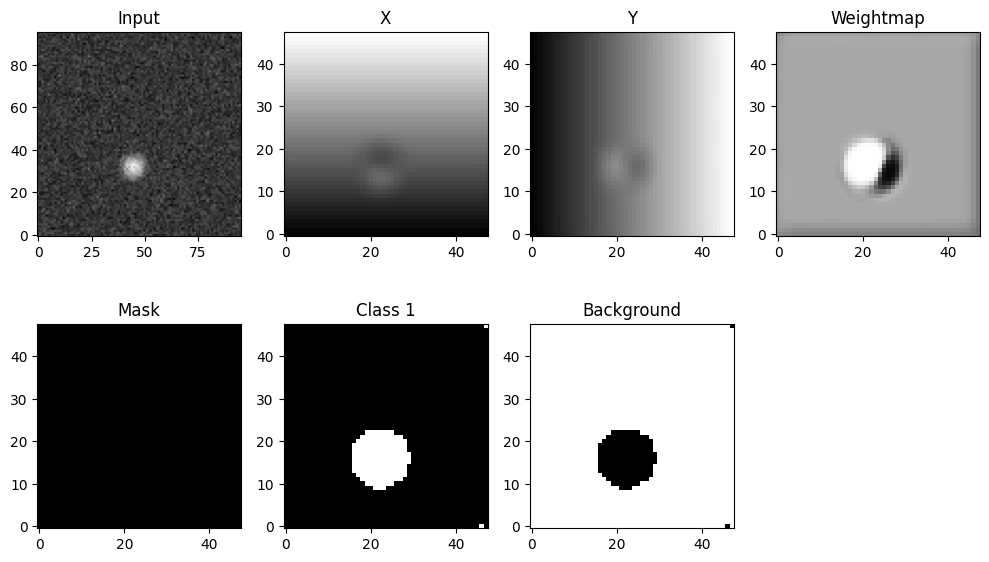

In [11]:
lodestar2_C.eval()
data, *_ = next(iter(test_dataloader_C))
output = lodestar2_C((data)).detach()
import matplotlib.pyplot as plt

x = 0

plt.figure(figsize=(10, 6))
for i in range(7):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 6:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
	
plt.tight_layout()
plt.show()

In [12]:
outputs_C = []
for batch in test_dataloader_C:
    data, part1, pos1 = batch
    output = lodestar2_C((data)).detach()
    outputs_C.append(output)

outputs_C = torch.cat(outputs_C, dim=0)

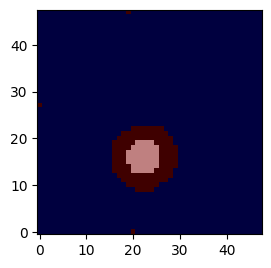

Class 1:
Jaccard Index: 0.7467
True positives %: 100%
False positives: 1.47


In [14]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_C, outputs_C)

### Moon particle

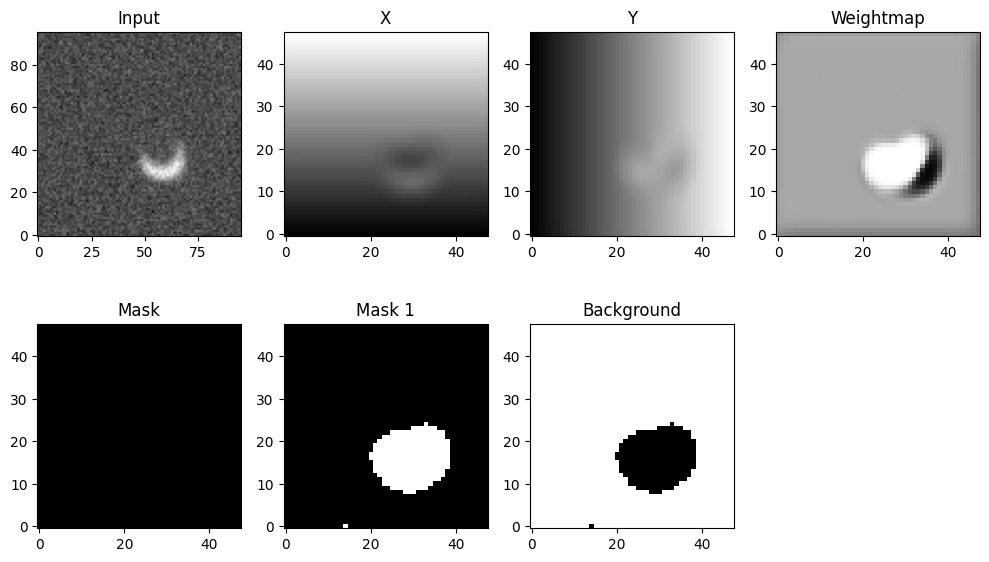

In [15]:
lodestar2_C.eval()
data,sim1, pos1 = next(iter(test_dataloader_M))
output = lodestar2_C((data)).detach()
import matplotlib.pyplot as plt

x = 0

plt.figure(figsize=(10, 6))
for i in range(7):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 6:
			plt.title('Mask ' + str(i-4))
		else:
			plt.title('Background')
	
plt.tight_layout()
plt.show()

In [16]:
outputs_M = []
for batch in test_dataloader_M:
    data, part1, pos1 = batch
    output = lodestar2_C((data)).detach()
    outputs_M.append(output)

outputs_M = torch.cat(outputs_M, dim=0)

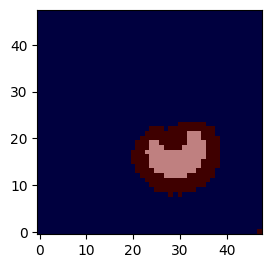

Class 1:
Jaccard Index: 0.7102
True positives %: 100%
False positives: 1.5


In [17]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_M, outputs_M)

### Star particle

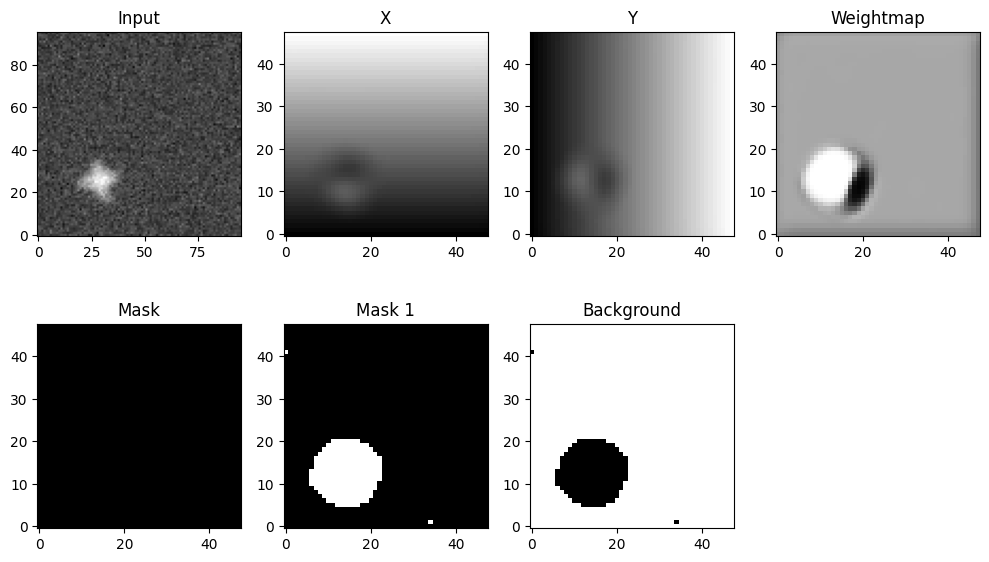

In [27]:
lodestar2_C.eval()
data,sim1, pos1 = next(iter(test_dataloader_S))
output = lodestar2_C((data)).detach()
import matplotlib.pyplot as plt

x = 0

plt.figure(figsize=(10, 6))
for i in range(7):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 6:
			plt.title('Mask ' + str(i-4))
		else:
			plt.title('Background')
	
plt.tight_layout()
plt.show()

In [28]:
outputs_S = []
for batch in test_dataloader_S:
    data, part1, pos1 = batch
    output = lodestar2_C((data)).detach()
    outputs_S.append(output)

outputs_S = torch.cat(outputs_S, dim=0)

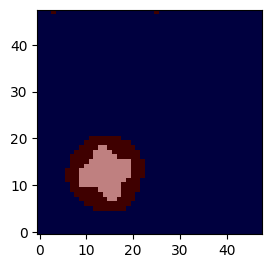

Class 1:
Jaccard Index: 0.7239
True positives %: 100%
False positives: 1.83


In [29]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_S, outputs_S)

### Filament shape

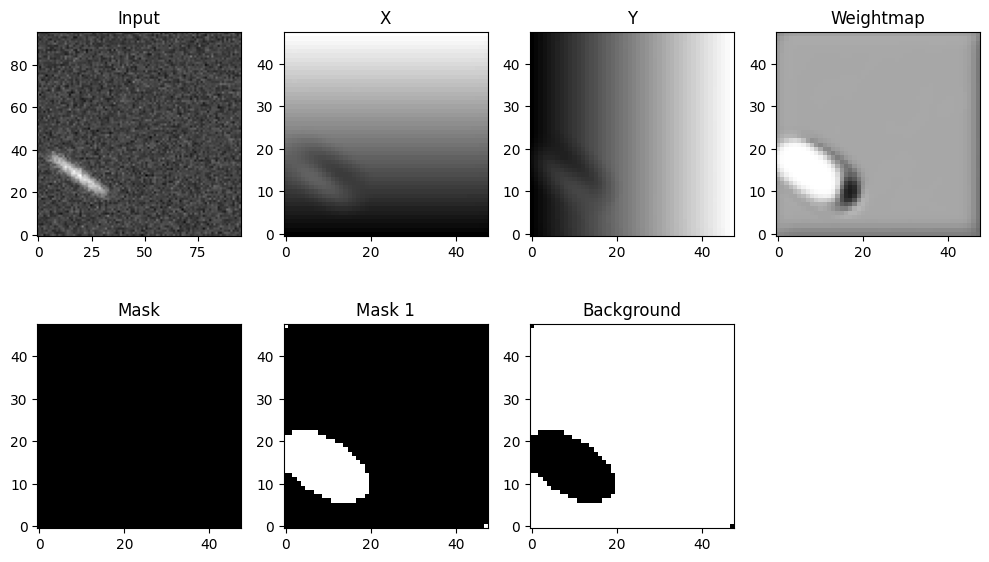

In [30]:
lodestar2_C.eval()
data,sim1, pos1 = next(iter(test_dataloader_F))
output = lodestar2_C((data)).detach()
import matplotlib.pyplot as plt

x = 0

plt.figure(figsize=(10, 6))
for i in range(7):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 6:
			plt.title('Mask ' + str(i-4))
		else:
			plt.title('Background')
	
plt.tight_layout()
plt.show()

In [31]:
outputs_F = []
for batch in test_dataloader_F:
    data, part1, pos1 = batch
    output = lodestar2_C((data)).detach()
    outputs_F.append(output)

outputs_F = torch.cat(outputs_F, dim=0)

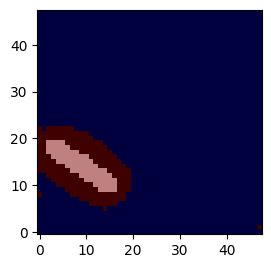

Class 1:
Jaccard Index: 0.6794
True positives %: 100%
False positives: 1.64


In [32]:
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_F, outputs_F)

## 2 classes

### CE

In [31]:
import deeplay as dl

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestar_CE = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestar_CE.fit(lodestar2_CE, train_dataloader_CE)

# torch.save(lodestar2_CE.state_dict(), "models/lodestar2_CE.pth")

# lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# lodestar2_CE.load_state_dict(torch.load('models/lodestar2_CE.pth'))
# lodestar2_CE.eval()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


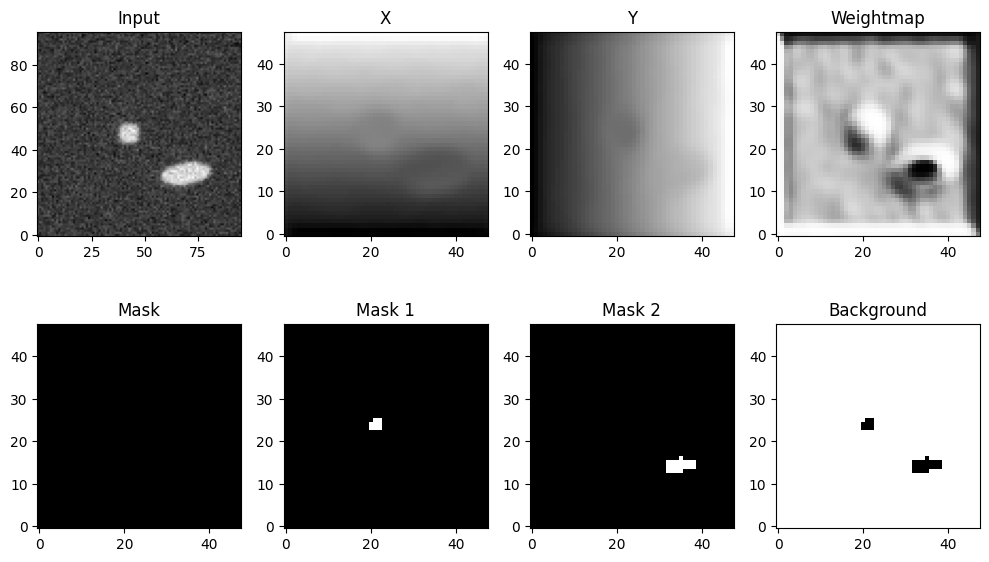

In [32]:
lodestar2_CE.eval()
data, *_ = next(iter(test_dataloader_CE))
output = lodestar2_CE((data)).detach()
import matplotlib.pyplot as plt

x = 5

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Mask ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

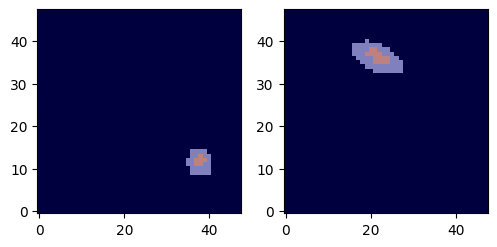

Class 1:
Jaccard Index: 0.2074
True positives %: 99%
False positives: 0.07
Class 2:
Jaccard Index: 0.2833
True positives %: 99%
False positives: 0.03


In [33]:
outputs_CE = []
for batch in test_dataloader_CE:
    data, *_ = batch
    output = lodestar2_CE((data)).detach()
    outputs_CE.append(output)

outputs_CE = torch.cat(outputs_CE, dim=0)
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_CE, outputs_CE)

Losses:
between_image_disagreement: 0.0502
within_image_disagreement: 0.0214
mask_loss: 0.0000


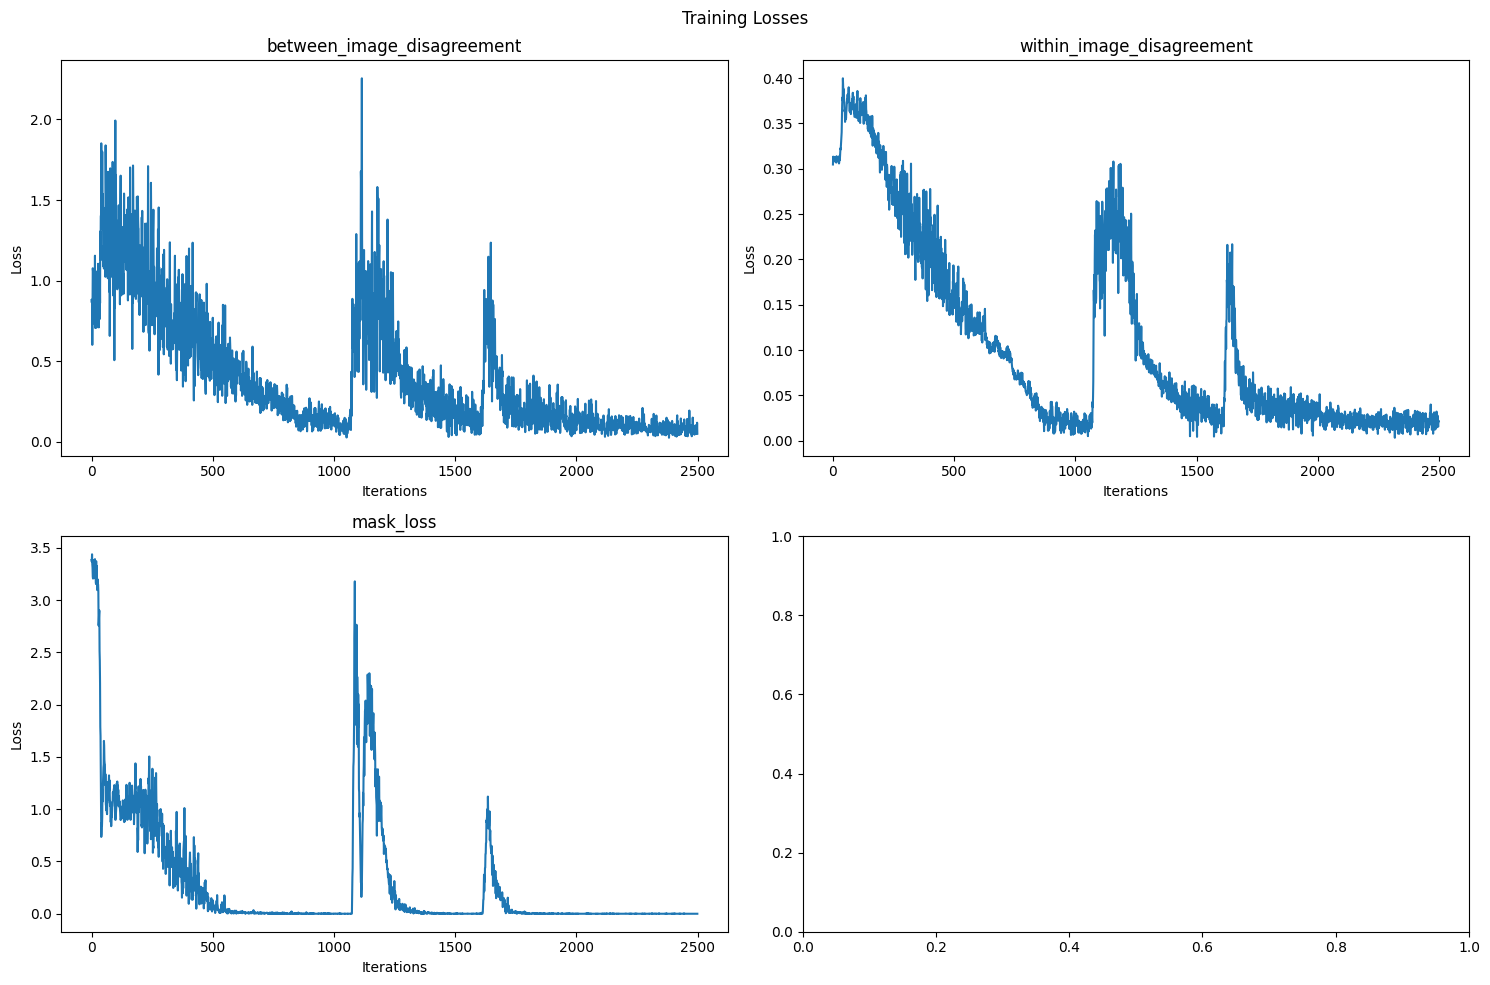

In [34]:
losses = lodestar2_CE.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CE.plot_losses()

### CM

In [22]:
import deeplay as dl

# lodestar2_CM = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# trainer_lodestar_CM = dl.Trainer(max_epochs=100, accelerator='cpu')
# trainer_lodestar_CM.fit(lodestar2_CM, train_dataloader_CM)

# torch.save(lodestar2_CM.state_dict(), "models/lodestar2_CM.pth")

lodestar2_CM = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CM.load_state_dict(torch.load('models/lodestar2_CM.pth'))
lodestar2_CM.eval()

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

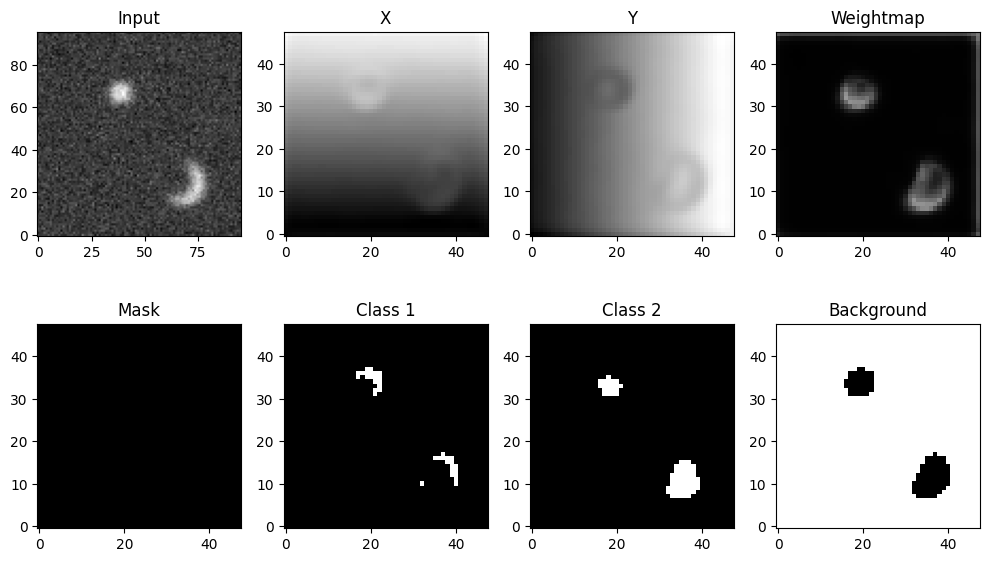

In [23]:
lodestar2_CM.eval()
data, *_ = next(iter(test_dataloader_CM))
output = lodestar2_CM((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

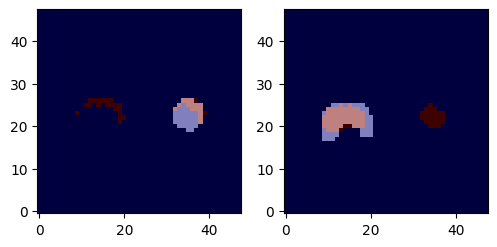

Class 1:
Jaccard Index: 0.7264
True positives %: 0%
False positives: 5.09
Class 2:
Jaccard Index: 0.7904
True positives %: 11%
False positives: 1.6


In [37]:
from segmentation_tests import segmentation_tests

outputs_CM = []
for batch in test_dataloader_CM:
    data, *_ = batch
    output = lodestar2_CM((data)).detach()
    outputs_CM.append(output)

outputs_CM = torch.cat(outputs_CM, dim=0)

segmentation_tests(test_dataset_CM, outputs_CM)

### CS

In [11]:
import deeplay as dl

# lodestar2_CS = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# trainer_lodestar_CS = dl.Trainer(max_epochs=100, accelerator='cpu')
# trainer_lodestar_CS.fit(lodestar2_CS, train_dataloader_CS)

# torch.save(lodestar2_CS.state_dict(), "models/lodestar2_CS.pth")

lodestar2_CS = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CS.load_state_dict(torch.load('models/lodestar2_CS.pth'))
lodestar2_CS.eval()

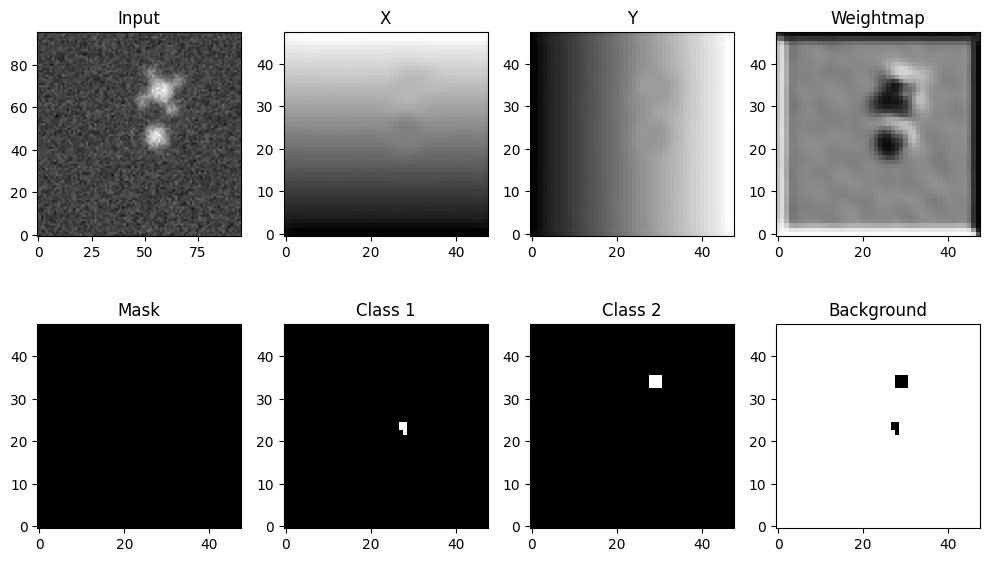

In [20]:
lodestar2_CS.eval()
data, *_ = next(iter(test_dataloader_CS))
output = lodestar2_CS((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

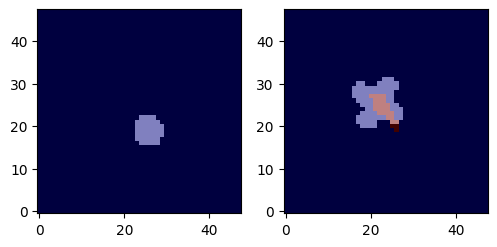

Class 1:
Jaccard Index: 0.8611
True positives %: 71%
False positives: 0.2
Class 2:
Jaccard Index: 0.7746
True positives %: 92%
False positives: 0.11


In [13]:
from segmentation_tests import segmentation_tests

outputs_CS = []
for batch in test_dataloader_CS:
    data, *_ = batch
    output = lodestar2_CS((data)).detach()
    outputs_CS.append(output)

outputs_CS = torch.cat(outputs_CS, dim=0)

segmentation_tests(test_dataset_CS, outputs_CS)

### CF

In [15]:
import deeplay as dl

# lodestar2_CF = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# trainer_lodestar_CF = dl.Trainer(max_epochs=100, accelerator='cpu')
# trainer_lodestar_CF.fit(lodestar2_CF, train_dataloader_CF)

# torch.save(lodestar2_CF.state_dict(), "models/lodestar2_CF.pth")

lodestar2_CF = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CF.load_state_dict(torch.load('models/lodestar2_CF.pth'))
lodestar2_CF.eval()

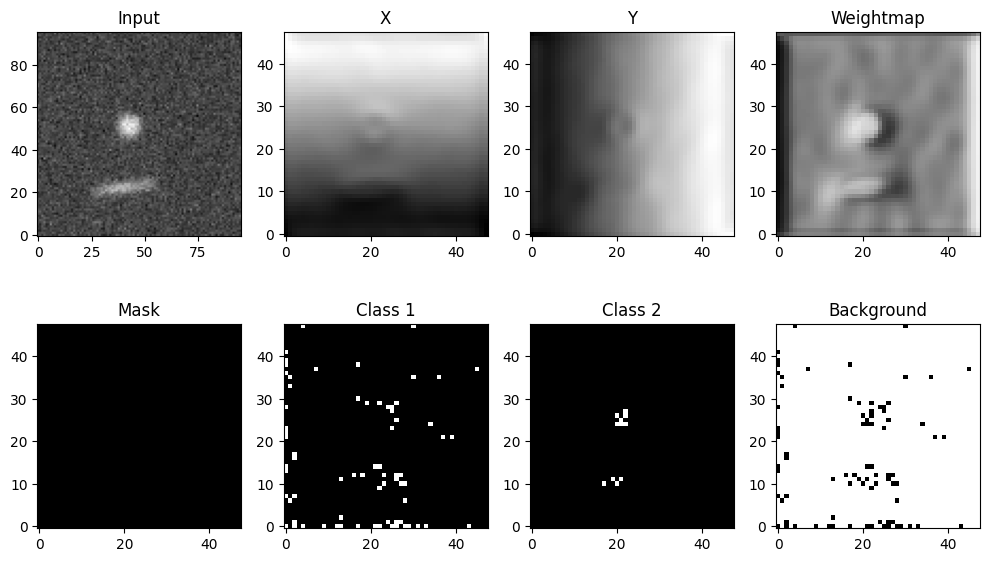

In [19]:
lodestar2_CF.eval()
data, *_ = next(iter(test_dataloader_CF))
output = lodestar2_CF((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

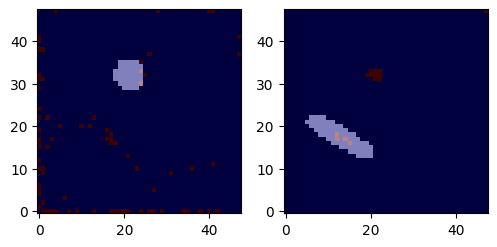

Class 1:
Jaccard Index: 0.2971
True positives %: 0%
False positives: 50.55
Class 2:
Jaccard Index: 0.6891
True positives %: 28%
False positives: 3.24


In [17]:
from segmentation_tests import segmentation_tests

outputs_CF = []
for batch in test_dataloader_CF:
    data, *_ = batch
    output = lodestar2_CF((data)).detach()
    outputs_CF.append(output)

outputs_CF = torch.cat(outputs_CF, dim=0)

segmentation_tests(test_dataset_CF, outputs_CF)

### CSq

In [3]:
import deeplay as dl

lodestar2_CSq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestar_CSq = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestar_CSq.fit(lodestar2_CSq, train_dataloader_CSq)

# torch.save(lodestar2_CSq.state_dict(), "models/lodestar2_CSq.pth")

# lodestar2_CSq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# lodestar2_CSq.load_state_dict(torch.load('models/lodestar2_CSq.pth'))
# lodestar2_CSq.eval()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


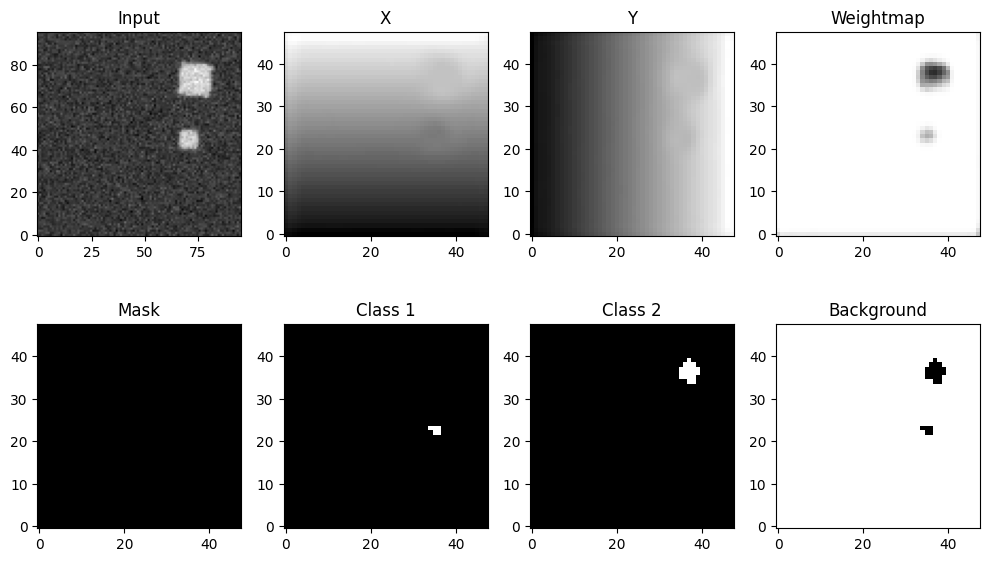

In [4]:
lodestar2_CSq.eval()
data, *_ = next(iter(test_dataloader_CSq))
output = lodestar2_CSq((data)).detach()
import matplotlib.pyplot as plt

x = 7

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

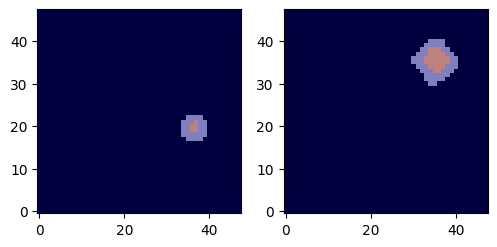

Class 1:
Jaccard Index: 0.1591
True positives %: 91%
False positives: 0.11
Class 2:
Jaccard Index: 0.2915
True positives %: 100%
False positives: 0.01


In [5]:
from segmentation_tests import segmentation_tests

outputs_CSq = []
for batch in test_dataloader_CSq:
    data, *_ = batch
    output = lodestar2_CSq((data)).detach()
    outputs_CSq.append(output)

outputs_CSq = torch.cat(outputs_CSq, dim=0)

segmentation_tests(test_dataset_CSq, outputs_CSq)

### ESq

In [26]:
import deeplay as dl

lodestar2_ESq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
trainer_lodestar_ESq = dl.Trainer(max_epochs=100, accelerator='cpu')
trainer_lodestar_ESq.fit(lodestar2_ESq, train_dataloader_ESq)

# torch.save(lodestar2_ESq.state_dict(), "models/lodestar2_ESq.pth")

# lodestar2_ESq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# lodestar2_ESq.load_state_dict(torch.load('models/lodestar2_ESq.pth'))
# lodestar2_ESq.eval()

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  252 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 252 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 252 K                                                                                                
Total estimated model params size (MB): 1

Output()

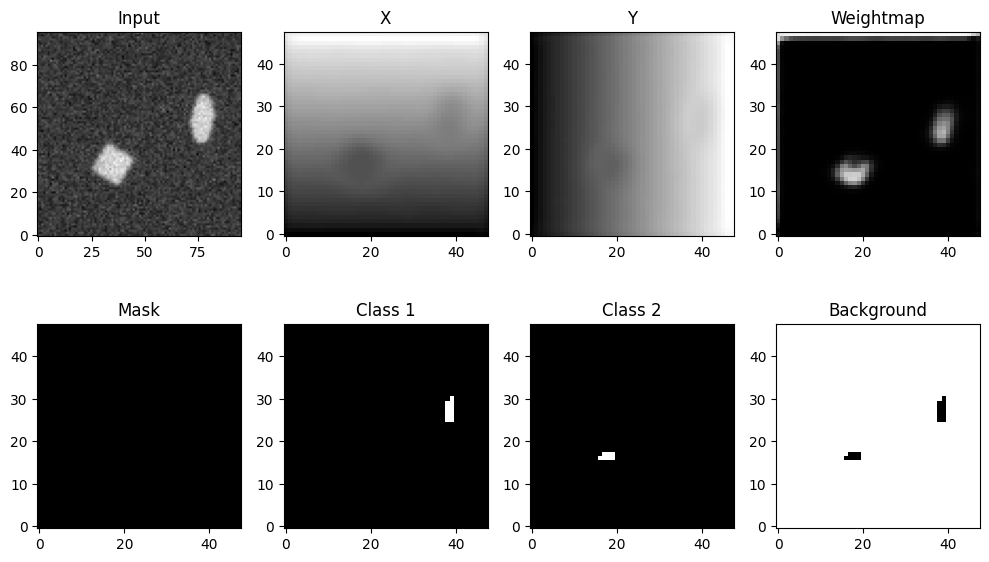

In [27]:
lodestar2_ESq.eval()
data, *_ = next(iter(test_dataloader_ESq))
output = lodestar2_ESq((data)).detach()
import matplotlib.pyplot as plt

x = 1

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

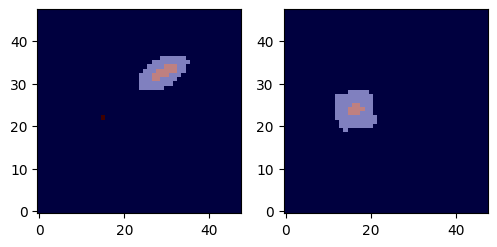

Class 1:
Jaccard Index: 0.1655
True positives %: 98%
False positives: 0.16
Class 2:
Jaccard Index: 0.1157
True positives %: 98%
False positives: 0.01


In [28]:
from segmentation_tests import segmentation_tests

outputs_ESq = []
for batch in test_dataloader_ESq:
    data, *_ = batch
    output = lodestar2_ESq((data)).detach()
    outputs_ESq.append(output)

outputs_ESq = torch.cat(outputs_ESq, dim=0)

segmentation_tests(test_dataset_ESq, outputs_ESq)

Losses:
between_image_disagreement: 0.1096
within_image_disagreement: 0.0262
mask_loss: 0.0024


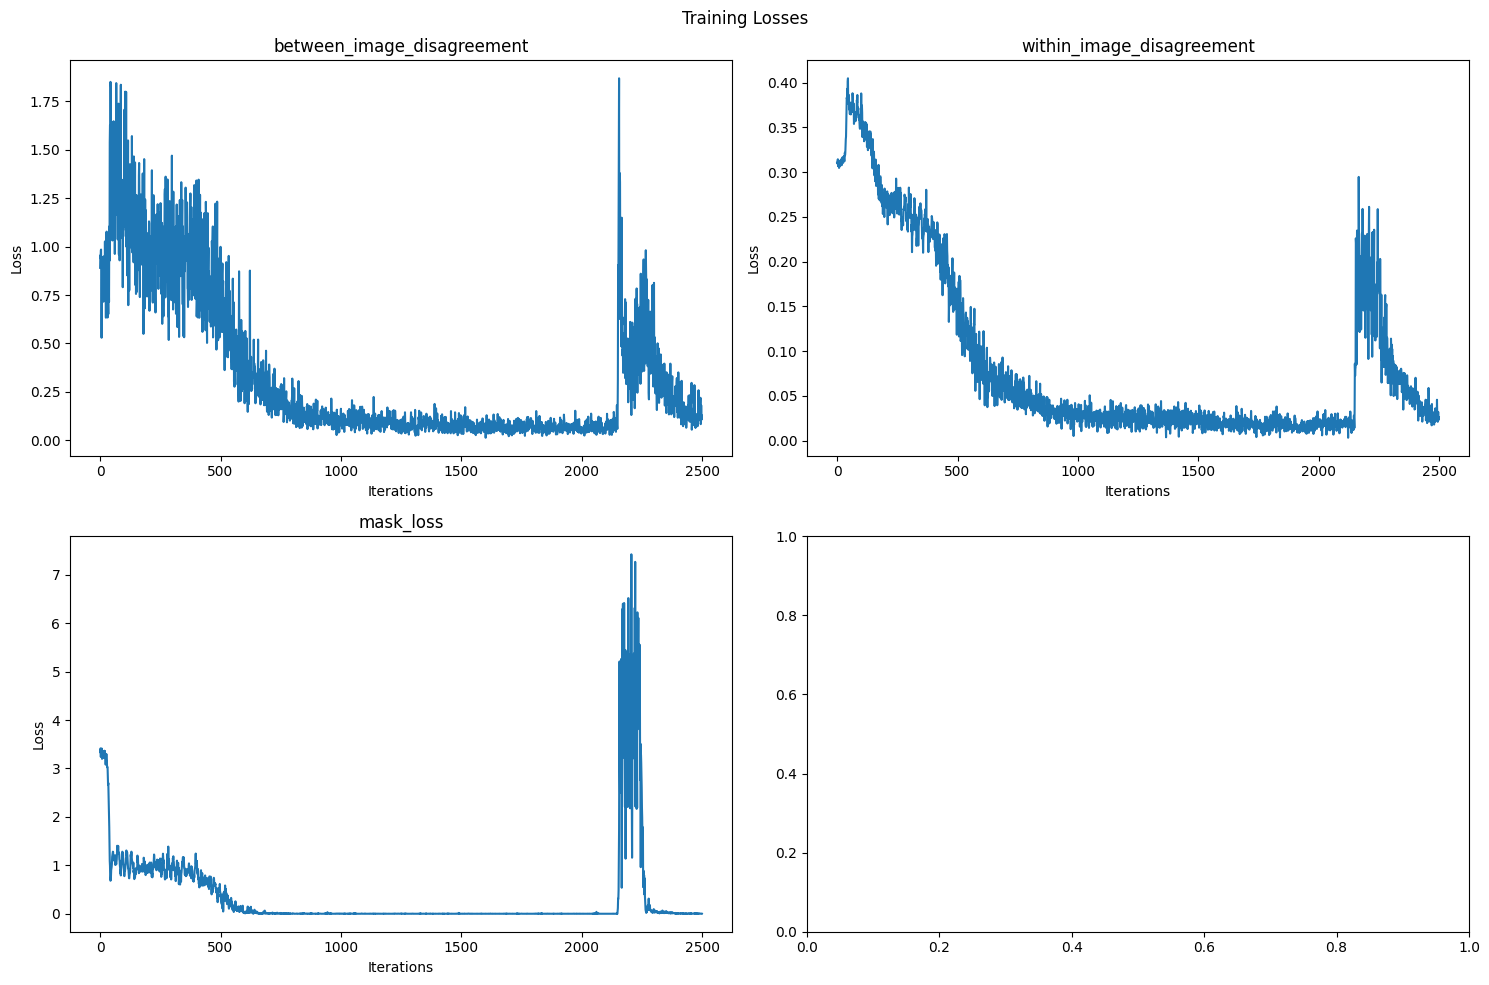

In [30]:
losses = lodestar2_ESq.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_ESq.plot_losses()

## 3 particles

### CEM

In [11]:
import deeplay as dl

lodestar2_CEM = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
trainer_lodestar_CEM = dl.Trainer(max_epochs=21, accelerator='cpu')
trainer_lodestar_CEM.fit(lodestar2_CEM, train_dataloader_CEM)

# torch.save(lodestar2_CEM.state_dict(), "models/lodestar2_CEM.pth")

# lodestar2_CEM = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
# lodestar2_CEM.load_state_dict(torch.load('models/lodestar2_CEM.pth'))
# lodestar2_CEM.eval()

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  253 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 253 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 253 K                                                                                                
Total estimated model params size (MB): 1

Output()

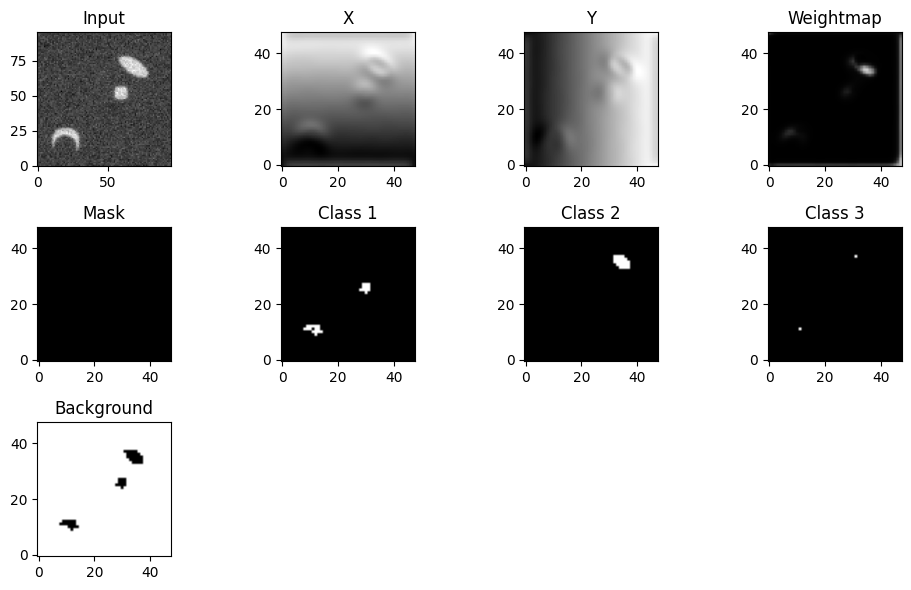

In [12]:
lodestar2_CEM.eval()
data, *_ = next(iter(test_dataloader_CEM))
output = lodestar2_CEM((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(9):
	plt.subplot(3, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 8:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

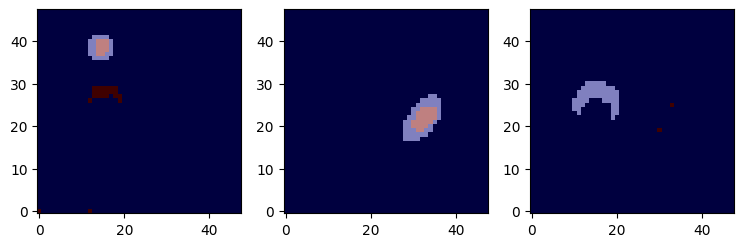

Class 1:
Jaccard Index: 0.2331
True positives %: 100%
False positives: 4.38
Class 2:
Jaccard Index: 0.3474
True positives %: 99%
False positives: 0.0
Class 3:
Jaccard Index: 0.0403
True positives %: 32%
False positives: 2.0


In [13]:
from segmentation_tests import segmentation_tests

outputs_CEM = []
for batch in test_dataloader_CEM:
    data, *_ = batch
    output = lodestar2_CEM((data)).detach()
    outputs_CEM.append(output)

outputs_CEM = torch.cat(outputs_CEM, dim=0)

segmentation_tests(test_dataset_CEM, outputs_CEM)

Losses:
between_image_disagreement: 0.4631
within_image_disagreement: 0.0978
mask_loss: 0.0928


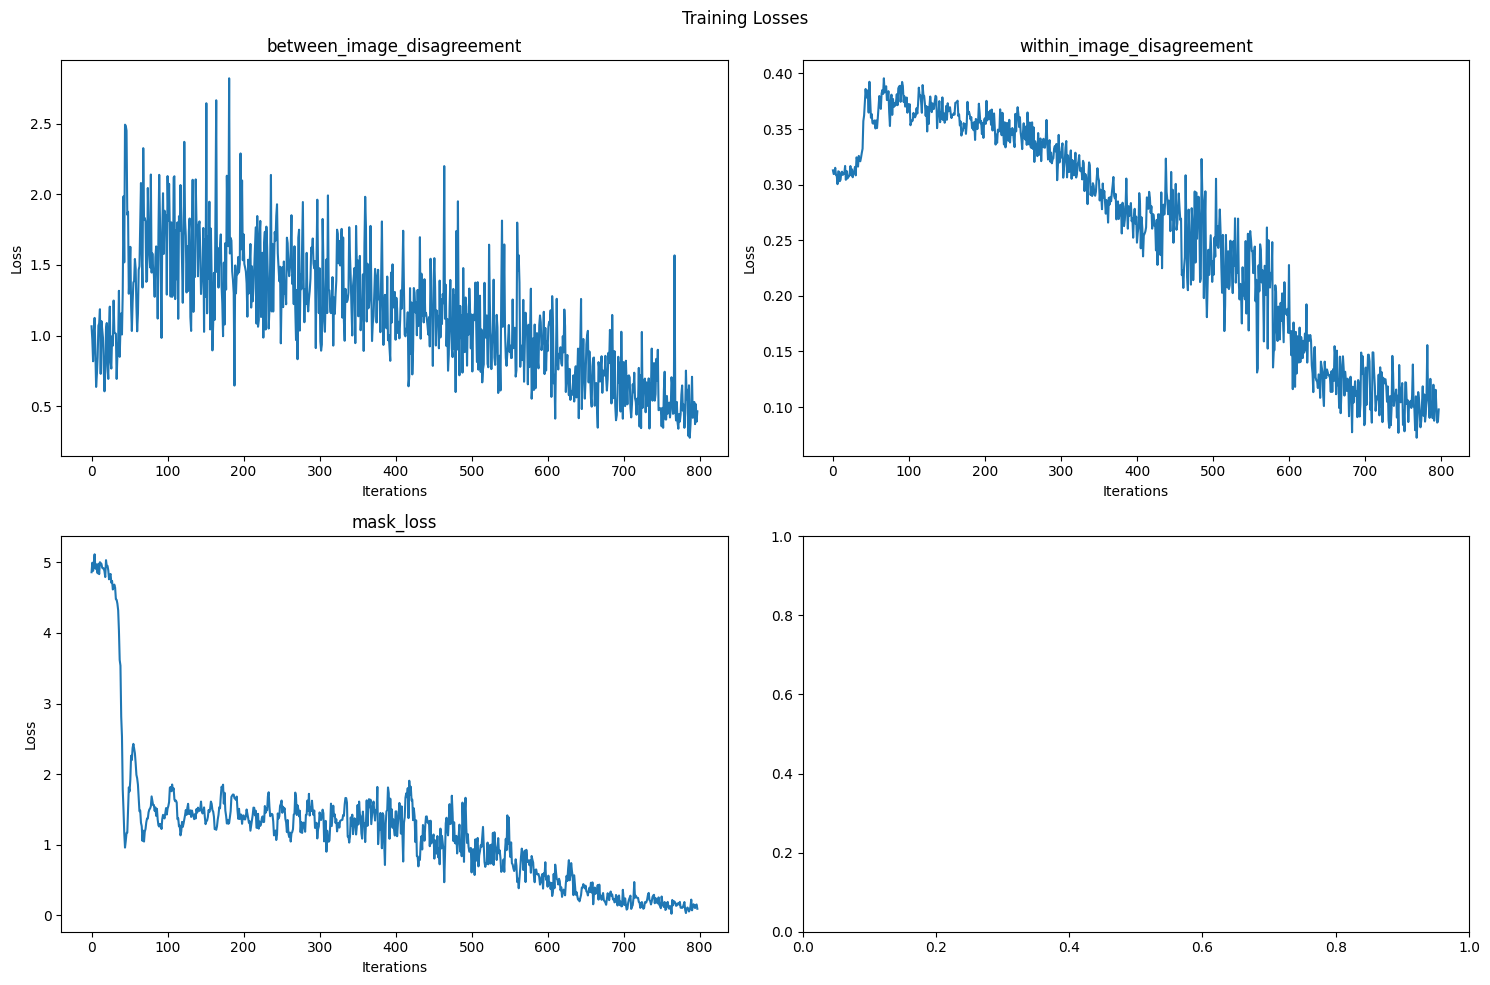

In [14]:
losses = lodestar2_CEM.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CEM.plot_losses()

### CES

In [30]:
import deeplay as dl

lodestar2_CES = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
trainer_lodestar_CES = dl.Trainer(max_epochs=150, accelerator='cpu')
trainer_lodestar_CES.fit(lodestar2_CES, train_dataloader_CES)

# torch.save(lodestar2_CES.state_dict(), "models/lodestar2_CES.pth")

# lodestar2_CES = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
# lodestar2_CES.load_state_dict(torch.load('models/lodestar2_CES.pth'))
# lodestar2_CES.eval()

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  253 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 253 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 253 K                                                                                                
Total estimated model params size (MB): 1

Output()

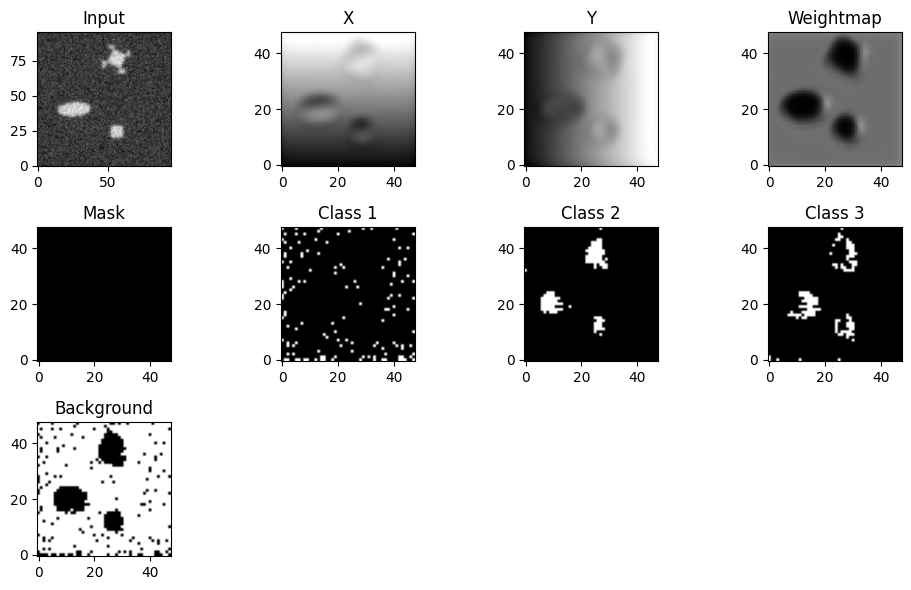

In [31]:
lodestar2_CES.eval()
data, *_ = next(iter(test_dataloader_CES))
output = lodestar2_CES((data)).detach()
import matplotlib.pyplot as plt

x = 4

plt.figure(figsize=(10, 6))
for i in range(9):
	plt.subplot(3, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 8:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

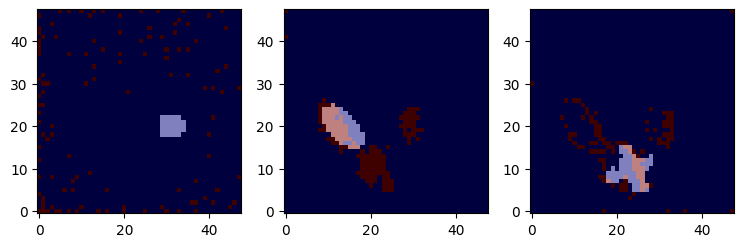

Class 1:
Jaccard Index: 0.0000
True positives %: 0%
False positives: 103.19
Class 2:
Jaccard Index: 0.1970
True positives %: 57%
False positives: 8.26
Class 3:
Jaccard Index: 0.1644
True positives %: 32%
False positives: 26.83


In [32]:
from segmentation_tests import segmentation_tests

outputs_CES = []
for batch in test_dataloader_CES:
    data, *_ = batch
    output = lodestar2_CES((data)).detach()
    outputs_CES.append(output)

outputs_CES = torch.cat(outputs_CES, dim=0)

segmentation_tests(test_dataset_CES, outputs_CES)

Losses:
between_image_disagreement: 0.6260
within_image_disagreement: 0.1578
mask_loss: 2.7393


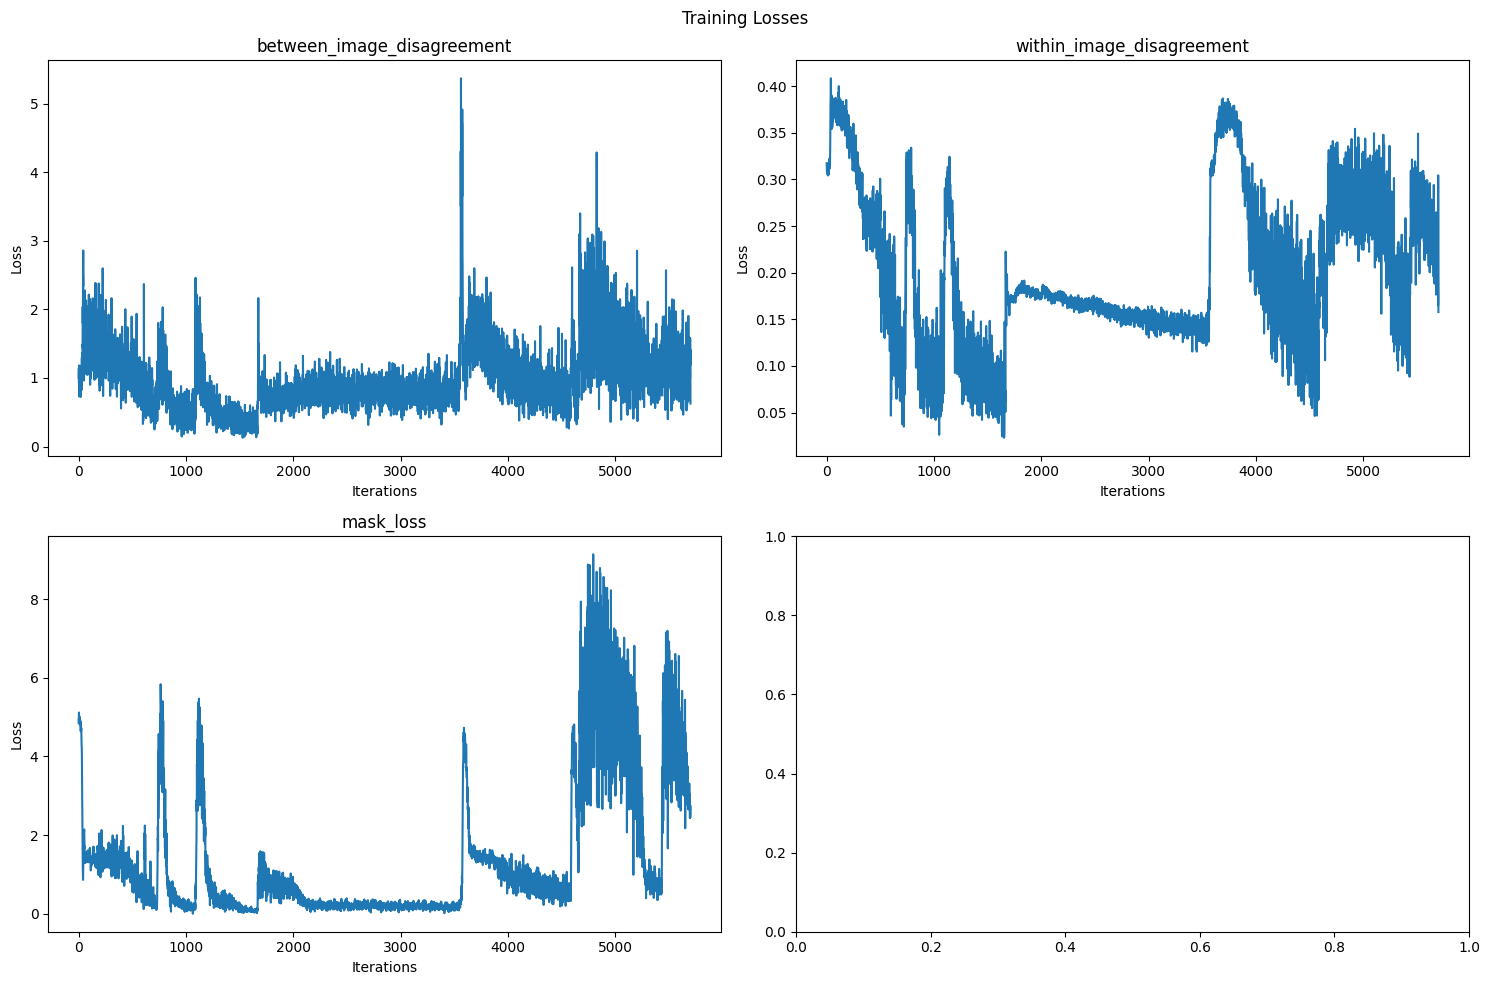

In [33]:
losses = lodestar2_CES.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CES.plot_losses()

### CEF

In [27]:
import deeplay as dl

# lodestar2_CEF = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
# trainer_lodestar_CEF = dl.Trainer(max_epochs=100, accelerator='cpu')
# trainer_lodestar_CEF.fit(lodestar2_CEF, train_dataloader_CEF)

# torch.save(lodestar2_CEF.state_dict(), "models/lodestar2_CEF.pth")

lodestar2_CEF = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
lodestar2_CEF.load_state_dict(torch.load('models/lodestar2_CEF.pth'))
lodestar2_CEF.eval()

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

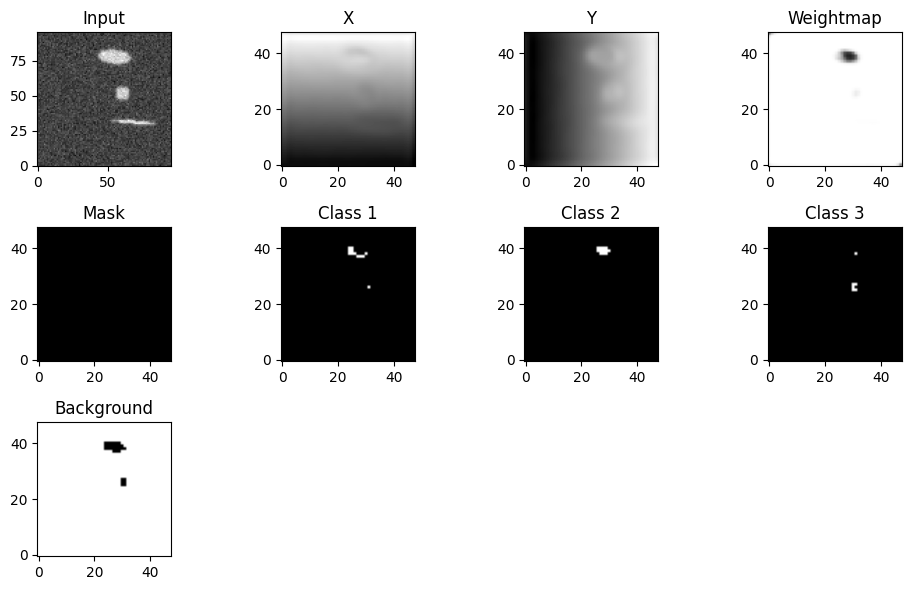

In [28]:
lodestar2_CEF.eval()
data, *_ = next(iter(test_dataloader_CEF))
output = lodestar2_CEF((data)).detach()
import matplotlib.pyplot as plt

x = 2

plt.figure(figsize=(10, 6))
for i in range(9):
	plt.subplot(3, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 8:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

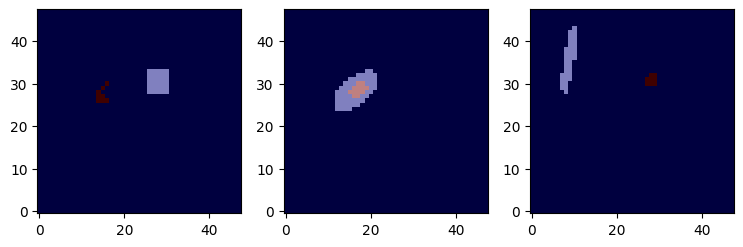

Class 1:
Jaccard Index: 0.0074
True positives %: 14%
False positives: 2.11
Class 2:
Jaccard Index: 0.1571
True positives %: 73%
False positives: 0.24
Class 3:
Jaccard Index: 0.0000
True positives %: 0%
False positives: 2.18


In [29]:
from segmentation_tests import segmentation_tests

outputs_CEF = []
for batch in test_dataloader_CEF:
    data, *_ = batch
    output = lodestar2_CEF((data)).detach()
    outputs_CEF.append(output)

outputs_CEF = torch.cat(outputs_CEF, dim=0)

segmentation_tests(test_dataset_CEF, outputs_CEF)

### CESq

In [35]:
import deeplay as dl

lodestar2_CESq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
trainer_lodestar_CESq = dl.Trainer(max_epochs=40, accelerator='cpu')
trainer_lodestar_CESq.fit(lodestar2_CESq, train_dataloader_CESq)

# torch.save(lodestar2_CESq.state_dict(), "models/lodestar2_CESq.pth")

# lodestar2_CESq = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=3).build()
# lodestar2_CESq.load_state_dict(torch.load('models/lodestar2_CESq.pth'))
# lodestar2_CESq.eval()

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  253 K │
│ 1 │ between_loss  │ L1Loss                     │      0 │
│ 2 │ within_loss   │ L1Loss                     │      0 │
│ 3 │ train_metrics │ MetricCollection           │      0 │
│ 4 │ val_metrics   │ MetricCollection           │      0 │
│ 5 │ test_metrics  │ MetricCollection           │      0 │
│ 6 │ optimizer     │ Adam                       │      0 │
└───┴───────────────┴────────────────────────────┴────────┘

Trainable params: 253 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 253 K                                                                                                
Total estimated model params size (MB): 1

Output()

C:\Users\alons\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


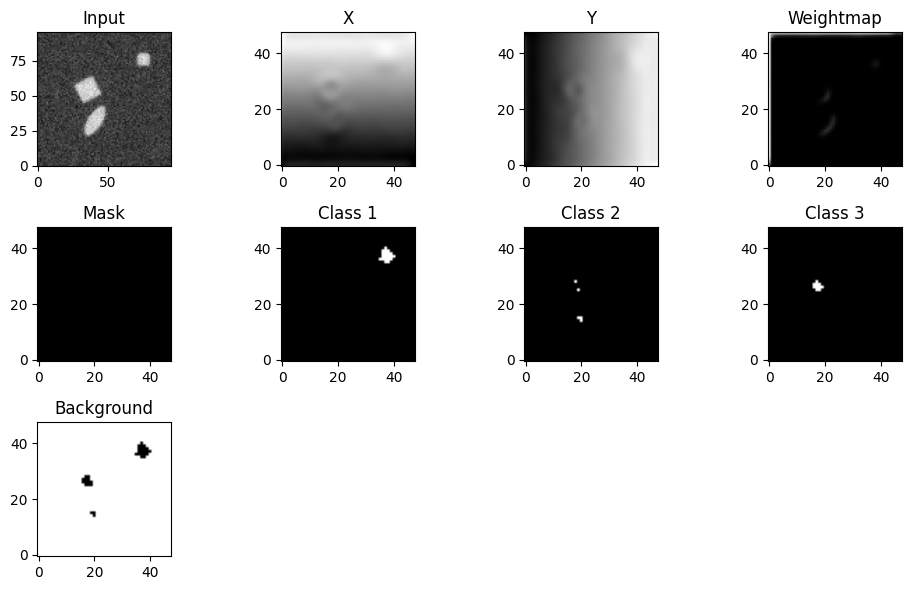

In [36]:
lodestar2_CESq.eval()
data, *_ = next(iter(test_dataloader_CESq))
output = lodestar2_CESq((data)).detach()
import matplotlib.pyplot as plt

x = 4

plt.figure(figsize=(10, 6))
for i in range(9):
	plt.subplot(3, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 8:
			plt.title('Class ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

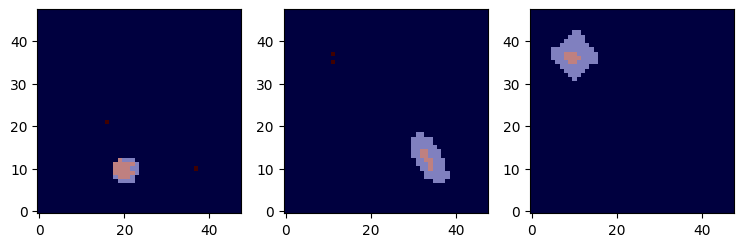

Class 1:
Jaccard Index: 0.5223
True positives %: 100%
False positives: 1.78
Class 2:
Jaccard Index: 0.0883
True positives %: 91%
False positives: 2.46
Class 3:
Jaccard Index: 0.0951
True positives %: 100%
False positives: 0.0


In [37]:
from segmentation_tests import segmentation_tests

outputs_CESq = []
for batch in test_dataloader_CESq:
    data, *_ = batch
    output = lodestar2_CESq((data)).detach()
    outputs_CESq.append(output)

outputs_CESq = torch.cat(outputs_CESq, dim=0)

segmentation_tests(test_dataset_CESq, outputs_CESq)

Losses:
between_image_disagreement: 0.5414
within_image_disagreement: 0.0963
mask_loss: 0.0244


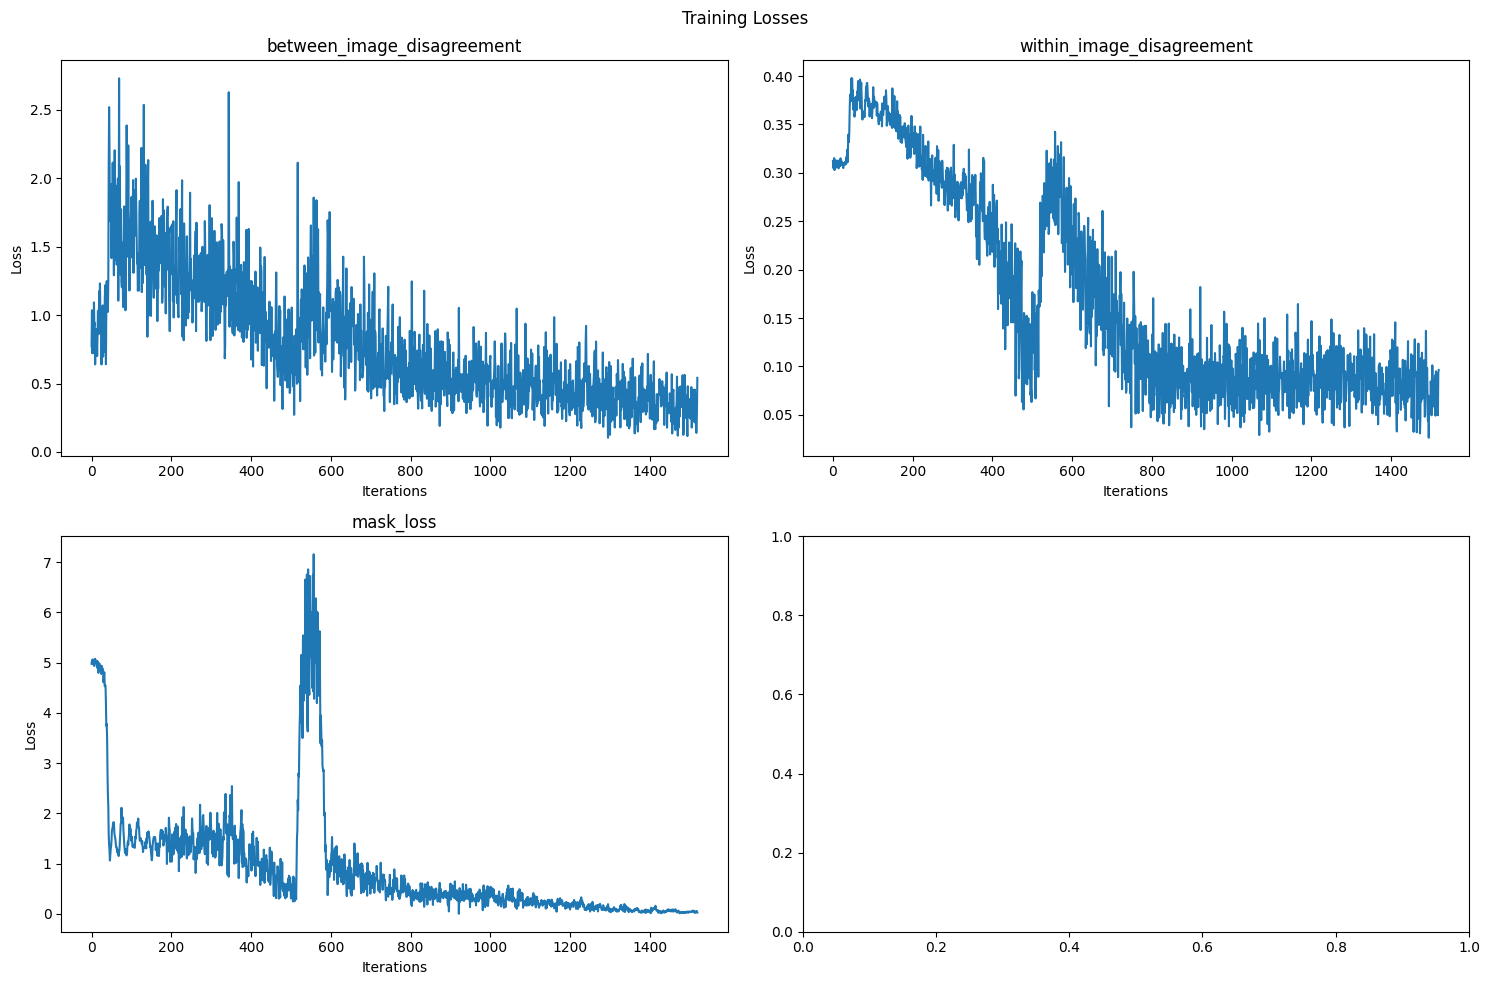

In [38]:
losses = lodestar2_CESq.get_losses()
print("Losses:")
for key, value in losses.items():
    print(f"{key}: {value[-1]:.4f}")

# Plot the losses
lodestar2_CESq.plot_losses()

## Dense dataset

In [21]:
import deeplay as dl

# lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
# trainer_lodestar_CE = dl.Trainer(max_epochs=100, accelerator='cpu')
# trainer_lodestar_CE.fit(lodestar2_CE, train_dataloader_CE)

# torch.save(lodestar2_CE.state_dict(), "models/lodestar2_CE.pth")

lodestar2_CE = LodeSTAR(optimizer=dl.Adam(lr=1e-4), num_classes=2).build()
lodestar2_CE.load_state_dict(torch.load('models/lodestar2_CE.pth'))
lodestar2_CE.eval()

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

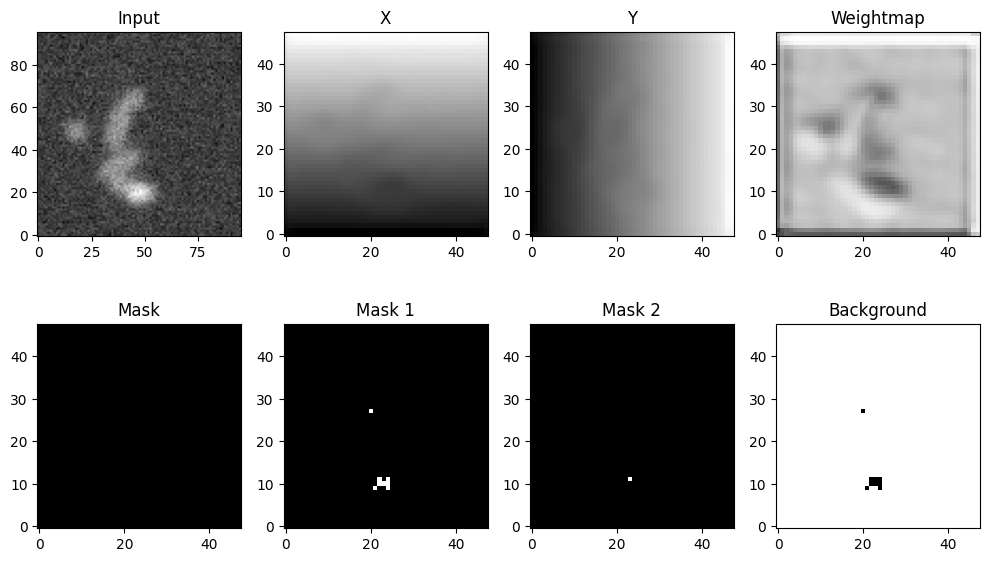

In [30]:
lodestar2_CE.eval()
data, *_ = next(iter(test_dataloader_CE_d))
output = lodestar2_CE((data)).detach()
import matplotlib.pyplot as plt

x = 5

plt.figure(figsize=(10, 6))
for i in range(8):
	plt.subplot(2, 4, i + 1)
	if i==0:
		plt.imshow(data[x,...].squeeze(), cmap="gray", origin="lower")
		plt.title('Input')
	elif i==1:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('X')
	elif i==2:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Y')
	elif i==3:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		plt.title('Weightmap')
	elif i==4:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower")
		plt.title('Mask')
	else:
		plt.imshow(output[x,i-1,...], cmap="gray", origin="lower", vmin=0,vmax=1)
		if i < 7:
			plt.title('Mask ' + str(i-4))
		else:
			plt.title('Background')
plt.tight_layout()
plt.show()

In [28]:
outputs_CE = []
for batch in test_dataloader_CE_d:
    data, *_ = batch
    output = lodestar2_CE((data)).detach()
    outputs_CE.append(output)

outputs_CE = torch.cat(outputs_CE, dim=0)
from segmentation_tests import segmentation_tests

segmentation_tests(test_dataset_CE_d, outputs_CE)

IndexError: tuple index out of range

## Plots multiple runs

C:\Users\alons\AppData\Local\Temp\ipykernel_8552\2867761877.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Jaccard adj', data=df, width=0.5, palette=colors)


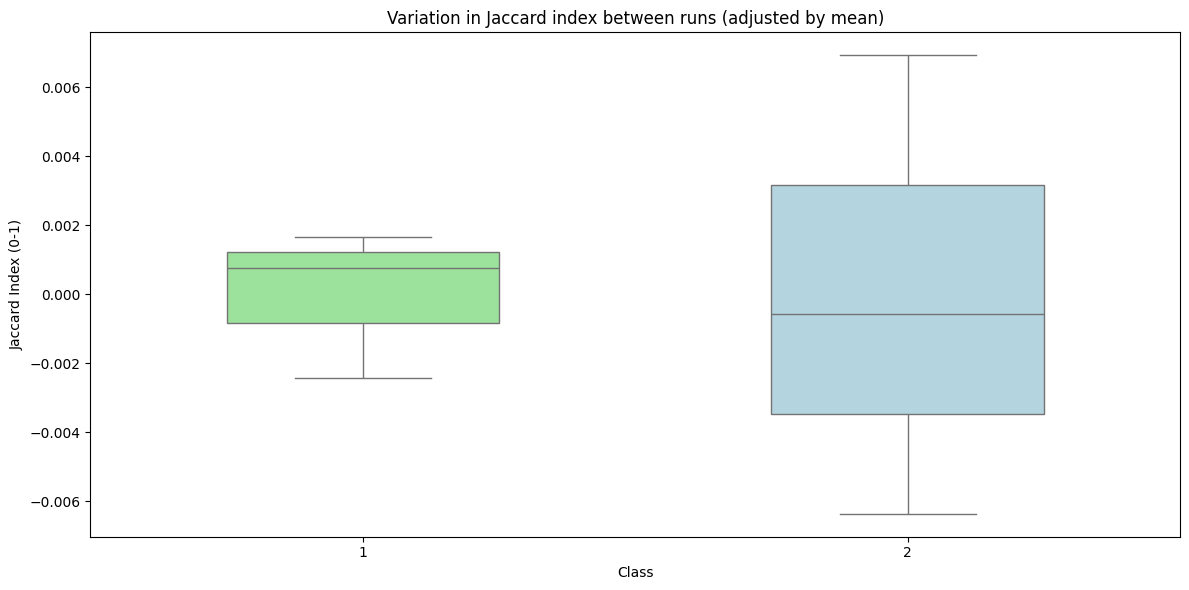

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the Excel file
df = pd.read_excel('data_CE_runs.xlsx')

# Get unique classes
classes = df['Class'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))

# Define colors for each class
colors = ['lightgreen', 'lightblue']  # You can change these colors as desired

# Create boxplot with different colors for each class
sns.boxplot(x='Class', y='Jaccard adj', data=df, width=0.5, palette=colors)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Jaccard Index (0-1)')
plt.title('Variation in Jaccard index between runs (adjusted by mean)')
plt.xticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

C:\Users\alons\AppData\Local\Temp\ipykernel_8552\658919071.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='True positives adj', data=df, width=0.5, palette=colors)


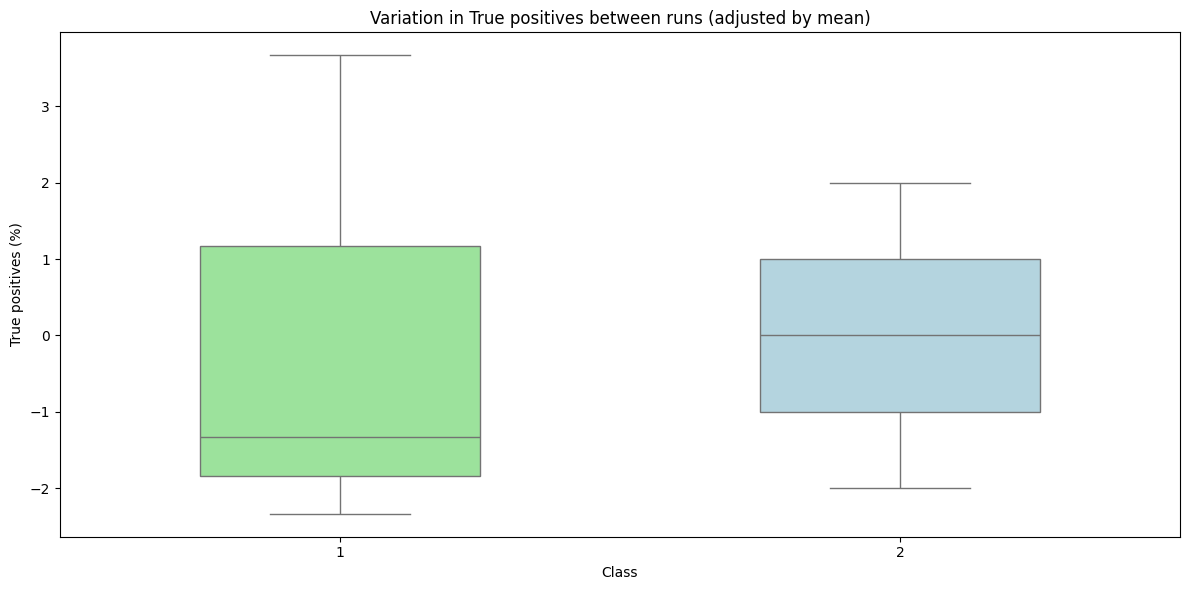

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the Excel file
df = pd.read_excel('data_CE_runs.xlsx')

# Get unique classes
classes = df['Class'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))

# Define colors for each class
colors = ['lightgreen', 'lightblue']  # You can change these colors as desired

# Create boxplot with different colors for each class
sns.boxplot(x='Class', y='True positives adj', data=df, width=0.5, palette=colors)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('True positives (%)')
plt.title('Variation in True positives between runs (adjusted by mean)')
plt.xticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


C:\Users\alons\AppData\Local\Temp\ipykernel_8552\1403204456.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='False positives adj', data=df, width=0.5, palette=colors)


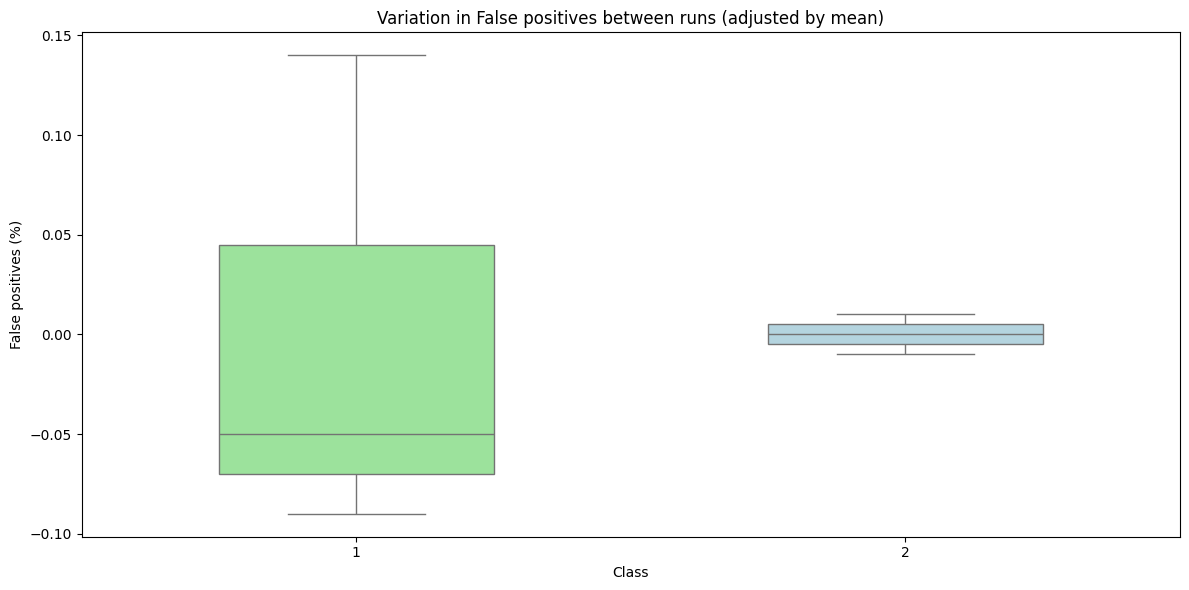

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the Excel file
df = pd.read_excel('data_CE_runs.xlsx')

# Get unique classes
classes = df['Class'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))

# Define colors for each class
colors = ['lightgreen', 'lightblue']  # You can change these colors as desired

# Create boxplot with different colors for each class
sns.boxplot(x='Class', y='False positives adj', data=df, width=0.5, palette=colors)

# Customize the plot
plt.xlabel('Class')
plt.ylabel('False positives (%)')
plt.title('Variation in False positives between runs (adjusted by mean)')
plt.xticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
